In [1]:
from cat import random_literal_cat
import matplotlib.pyplot as plt
import jax
import jax.random as random
import numpy as np
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
from mean_flows import *
from dataclasses import dataclass
from tqdm import tqdm
from typing import Optional, Tuple

### Check GPU Availabilility

In [2]:
# Check what devices JAX sees
devices = jax.devices()
print("JAX devices:")
for d in devices:
    print(" ", d)

# Check if GPU is available
if any(d.platform == "gpu" for d in devices):
    print("\n✅ GPU is available!")
else:
    print("\n❌ GPU is NOT available — JAX is running on CPU.")

# Run a small computation to confirm backend
x = jnp.ones((1000, 1000))
y = jnp.dot(x, x)
print(f"\nComputation result shape: {y.shape}")
print("Backend used:", jax.default_backend())

JAX devices:
  cuda:0

✅ GPU is available!

Computation result shape: (1000, 1000)
Backend used: gpu


### Target distribution

(2, 1000)


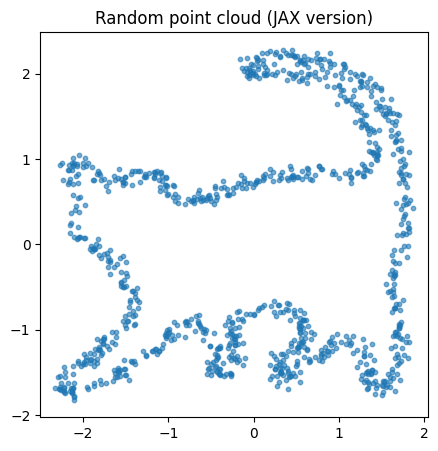

In [3]:
key = random.PRNGKey(0)
random_points = random_literal_cat(key, 1000)
print(random_points.shape)
x, y = random_points[0, :], random_points[1, :]
plt.figure(figsize=(5, 5))
plt.scatter(x, y, s=10, alpha=0.6)
plt.axis("equal")
plt.title("Random point cloud (JAX version)")
plt.show()

### Model:

In [4]:

# ----- data generator (your version) -----
def make_batch(key, batch_size):
    pts = random_literal_cat(key, batch_size)  # (2, B)
    return pts.T.astype(T)                     # (B, 2)

# ----- model -----
class VelocityMLP(nn.Module):
    hidden: int = 64
    out_dim: int = 2
    @nn.compact
    def __call__(self, z, r, t):
        r = jnp.asarray(r); t = jnp.asarray(t)
        if z.ndim == 1:
            if r.ndim == 0: r = r[None]
            if t.ndim == 0: t = t[None]
            h = jnp.concatenate([z, r, t], axis=-1)
        else:
            B = z.shape[0]
            if r.ndim == 0: r = jnp.full((B,), r, dtype=z.dtype)
            if t.ndim == 0: t = jnp.full((B,), t, dtype=z.dtype)
            h = jnp.concatenate([z, r[:, None], t[:, None]], axis=-1)
        h = nn.tanh(nn.Dense(self.hidden)(h))
        h = nn.tanh(nn.Dense(self.hidden)(h))
        h = nn.tanh(nn.Dense(self.hidden)(h))
        h = nn.tanh(nn.Dense(self.hidden)(h))
        h = nn.tanh(nn.Dense(self.hidden)(h))
        return nn.Dense(self.out_dim)(h)

class MFTrainState(train_state.TrainState): pass

def init_meanflow(rng, hidden=128):
    model = VelocityMLP(hidden=hidden, out_dim=2)
    z0 = jnp.zeros((1,2), dtype=T)
    r0 = jnp.array(0.0, dtype=T)
    t0 = jnp.array(1.0, dtype=T)
    params = model.init(rng, z0, r0, t0)["params"]
    tx = optax.adamw(2e-3)
    state = MFTrainState.create(apply_fn=model.apply, params=params, tx=tx)
    return state, model




In [5]:
T = jnp.float32

class RandomFourierFeatures(nn.Module):
    in_dim: int
    emb_dim: int
    sigma: float = 1.0  # similar to 1f0 in Julia code

    @nn.compact
    def __call__(self, x):
        # x: (B, in_dim)
        W = self.param(
            "W",
            nn.initializers.normal(stddev=1.0 / self.sigma),
            (self.in_dim, self.emb_dim),
        )
        b = self.param(
            "b",
            nn.initializers.uniform(scale=2 * jnp.pi),
            (self.emb_dim,),
        )
        proj = x @ W + b  # (B, emb_dim)
        return jnp.sqrt(2.0 / self.emb_dim) * jnp.cos(proj)

class MeanFlowFModel(nn.Module):
    embeddim: int = 128
    spacedim: int = 2
    layers: int = 3  # number of residual layers

    @nn.compact
    def __call__(self, z, r, t):
        """
        z: (B, spacedim)  - current state
        r: (B,) or scalar - lower time
        t: (B,) or scalar - upper time
        returns: (B, spacedim) velocity u(z, r, t)
        """
        z = jnp.asarray(z)
        B = z.shape[0]

        # --- broadcast r, t to (B, 1) ---
        r = jnp.asarray(r)
        t = jnp.asarray(t)

        if r.ndim == 0:
            r_vec = jnp.full((B, 1), r, dtype=z.dtype)
        elif r.ndim == 1:
            r_vec = r[:, None]
        else:
            r_vec = r  # assume already (B, 1) or compatible

        if t.ndim == 0:
            t_vec = jnp.full((B, 1), t, dtype=z.dtype)
        elif t.ndim == 1:
            t_vec = t[:, None]
        else:
            t_vec = t

        # --- time embedding: use (t, r) or (t, t-r) – here we pick (t, r) ---
        tr = jnp.concatenate([t_vec, r_vec], axis=-1)  # (B, 2)
        time_feat = RandomFourierFeatures(in_dim=2, emb_dim=self.embeddim)(tr)
        time_feat = nn.swish(nn.Dense(self.embeddim)(time_feat))

        # --- state embedding: z in R^spacedim ---
        state_feat = RandomFourierFeatures(in_dim=self.spacedim, emb_dim=self.embeddim)(z)
        state_feat = nn.swish(nn.Dense(self.embeddim)(state_feat))

        # combine time + state embeddings
        x = time_feat + state_feat  # (B, embeddim)

        # --- residual stack: x = x + ff(x) ---
        for i in range(self.layers):
            h = nn.swish(nn.Dense(self.embeddim, name=f"ff_{i}")(x))
            x = x + h

        # --- decode to velocity u(z, r, t) ---
        u = nn.Dense(self.spacedim, name="decode")(x)  # (B, spacedim)
        return u


In [6]:
from flax.training import train_state
import optax

class MFTrainState(train_state.TrainState):
    pass

def init_meanflow(rng, embeddim=256, layers=3, spacedim=2):
    model = MeanFlowFModel(embeddim=embeddim, layers=layers, spacedim=spacedim)

    z0 = jnp.zeros((1, spacedim), dtype=T)
    r0 = jnp.array(0.0, dtype=T)
    t0 = jnp.array(1.0, dtype=T)

    params = model.init(rng, z0, r0, t0)["params"]
    tx = optax.adamw(2e-3)
    state = MFTrainState.create(apply_fn=model.apply, params=params, tx=tx)
    return state, model


#### Train step and sampling:

In [7]:
def meanflow_train_step(state, key, x, ratio_of_sampling, distribution, sampler_args):
    def loss_fn(params):
        return algorithm_1_jit(
            state.apply_fn,    
            params, 
            x,
            key,
            ratio_of_sampling,
            distribution,
            sampler_args,
        )
    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)
meanflow_train_step_jit = jax.jit(meanflow_train_step, static_argnums=(3, 4, 5))

def sample_minibatch(state, key, batch_size, dim=2):
    def fn_p(z, r, t):
        return state.apply_fn({"params": state.params}, z, r, t)
    return algorithm_2_jit(fn_p, dim, key, batch_size, 200)  # (B,2)

In [8]:
def train_meanflow(num_steps, batch_size, embeddim, layers, seed, ratio_of_sampling, distribution, sampler_args):
    rng = random.PRNGKey(seed)
    rng, k_init = random.split(rng)
    state, _ = init_meanflow(k_init, embeddim=embeddim, layers=layers, spacedim=2)

    for step in tqdm(range(1, num_steps+1)):
        rng, k_data, k_step, k_log = random.split(rng, 4)
        x = make_batch(k_data, batch_size)  # (B,2), dtype T
        state = meanflow_train_step_jit(state, k_step, x, ratio_of_sampling, distribution, sampler_args)
        loss = algorithm_1(state.apply_fn, state.params, x, k_log, ratio_of_sampling, distribution, sampler_args)
        if step % 50 == 0:
            print(f"[step {step:4d}] loss={float(loss):.6f}")

    return rng, state

ratio_of_sampling = 0.25
distribution = "lognorm"
sampler_args = (-0.4, 1.0)
def demo_train_and_sample():
    rng, state = train_meanflow(2000, 2048, 256, 5, 0, ratio_of_sampling, distribution, sampler_args)

    rng, k_samp, k_real = random.split(rng, 3)
    gen = sample_minibatch(state, k_samp, batch_size=2048, dim=2)  # (2048,2)
    real = make_batch(k_real, 2048)

    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(5,5))
        plt.scatter(real[:,0], real[:,1], s=6, alpha=0.4, label="real")
        plt.scatter(gen[:,0],  gen[:,1],  s=6, alpha=0.4, label="gen")
        plt.axis("equal"); plt.legend(); plt.title("Mean Flow training (data space)")
        plt.show()
    except Exception as e:
        print("Plot skipped:", e)
    return state

  2%|█                                          | 49/2000 [00:24<11:08,  2.92it/s]

[step   50] loss=4.288555


  5%|██                                        | 100/2000 [00:41<11:45,  2.69it/s]

[step  100] loss=4.308112


  8%|███▏                                      | 150/2000 [00:57<08:53,  3.47it/s]

[step  150] loss=4.175674


 10%|████▏                                     | 200/2000 [01:15<10:42,  2.80it/s]

[step  200] loss=4.275809


 12%|█████▎                                    | 250/2000 [01:32<11:34,  2.52it/s]

[step  250] loss=4.232275


 15%|██████▎                                   | 300/2000 [01:50<11:07,  2.55it/s]

[step  300] loss=4.215610


 18%|███████▎                                  | 350/2000 [02:07<09:05,  3.03it/s]

[step  350] loss=4.137701


 20%|████████▍                                 | 400/2000 [02:24<08:56,  2.98it/s]

[step  400] loss=4.368918


 22%|█████████▍                                | 450/2000 [02:41<09:53,  2.61it/s]

[step  450] loss=4.216923


 25%|██████████▌                               | 500/2000 [02:58<05:41,  4.39it/s]

[step  500] loss=4.411848


 28%|███████████▌                              | 550/2000 [03:18<08:03,  3.00it/s]

[step  550] loss=4.400111


 30%|████████████▌                             | 600/2000 [03:34<07:48,  2.99it/s]

[step  600] loss=4.305030


 32%|█████████████▋                            | 650/2000 [03:53<07:47,  2.89it/s]

[step  650] loss=4.476630


 35%|██████████████▋                           | 700/2000 [04:10<07:30,  2.88it/s]

[step  700] loss=4.279582


 38%|███████████████▊                          | 750/2000 [04:29<07:34,  2.75it/s]

[step  750] loss=4.349003


 40%|████████████████▊                         | 800/2000 [04:44<06:36,  3.03it/s]

[step  800] loss=4.254301


 42%|█████████████████▊                        | 848/2000 [05:01<06:42,  2.86it/s]

[step  850] loss=4.160640


 45%|██████████████████▉                       | 900/2000 [05:17<06:17,  2.92it/s]

[step  900] loss=4.381118


 48%|███████████████████▉                      | 950/2000 [05:36<06:45,  2.59it/s]

[step  950] loss=4.051280


 50%|████████████████████▌                    | 1000/2000 [05:53<05:43,  2.91it/s]

[step 1000] loss=4.102165


 52%|█████████████████████▌                   | 1050/2000 [06:11<05:45,  2.75it/s]

[step 1050] loss=4.380252


 55%|██████████████████████▌                  | 1100/2000 [06:29<04:50,  3.10it/s]

[step 1100] loss=4.163431


 57%|███████████████████████▌                 | 1150/2000 [06:48<06:26,  2.20it/s]

[step 1150] loss=4.256995


 60%|████████████████████████▌                | 1200/2000 [07:05<03:06,  4.28it/s]

[step 1200] loss=4.315067


 62%|█████████████████████████▋               | 1250/2000 [07:23<04:21,  2.87it/s]

[step 1250] loss=4.316530


 65%|██████████████████████████▋              | 1300/2000 [07:40<03:56,  2.96it/s]

[step 1300] loss=4.392740


 68%|███████████████████████████▋             | 1350/2000 [07:59<03:52,  2.79it/s]

[step 1350] loss=4.310729


 70%|████████████████████████████▋            | 1400/2000 [08:17<03:41,  2.71it/s]

[step 1400] loss=4.143659


 72%|█████████████████████████████▋           | 1450/2000 [08:35<03:47,  2.41it/s]

[step 1450] loss=4.400969


 75%|██████████████████████████████▊          | 1500/2000 [08:53<03:25,  2.43it/s]

[step 1500] loss=4.133838


 78%|███████████████████████████████▊         | 1550/2000 [09:09<02:08,  3.49it/s]

[step 1550] loss=4.098041


 80%|████████████████████████████████▊        | 1600/2000 [09:26<02:13,  2.99it/s]

[step 1600] loss=4.243693


 82%|█████████████████████████████████▊       | 1650/2000 [09:42<01:49,  3.20it/s]

[step 1650] loss=4.161403


 85%|██████████████████████████████████▊      | 1700/2000 [10:02<01:42,  2.92it/s]

[step 1700] loss=4.111153


 88%|███████████████████████████████████▉     | 1750/2000 [10:18<01:28,  2.83it/s]

[step 1750] loss=4.101924


 90%|████████████████████████████████████▉    | 1800/2000 [10:37<01:10,  2.84it/s]

[step 1800] loss=4.077721


 92%|█████████████████████████████████████▉   | 1850/2000 [10:55<00:49,  3.01it/s]

[step 1850] loss=4.379644


 95%|██████████████████████████████████████▉  | 1900/2000 [11:12<00:36,  2.71it/s]

[step 1900] loss=4.236080


 98%|███████████████████████████████████████▉ | 1950/2000 [11:31<00:18,  2.72it/s]

[step 1950] loss=4.233851


100%|█████████████████████████████████████████| 2000/2000 [11:49<00:00,  2.82it/s]

[step 2000] loss=4.369711


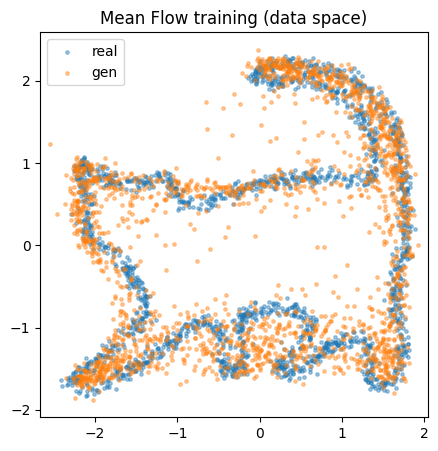

In [9]:
state = demo_train_and_sample()